# Training with Tensorflow Keras

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import ELU
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import TensorBoard

from IPython.display import SVG
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt

In [2]:
# To disable warning. 
# See https://stackoverflow.com/questions/43337601/nosetests-with-tensorflow-lots-of-debugging-output-how-to-disable
import logging
logging.getLogger('tensorflow').disabled = True 

## Model definition

In [3]:
def build_simplenet(input_shape=(64,64,3),n_output_classes=2):
    model = Sequential()
    
    # Convolution + Pooling #1
    model.add(Conv2D( 32, (3, 3), input_shape=input_shape,
                          activation = 'relu' ))        
    model.add( MaxPooling2D(pool_size = (2,2)))
    
    # Convolution + Pooling #2
    model.add(Conv2D( 32, (3, 3), activation = 'relu' ))        
    model.add( MaxPooling2D(pool_size = (2,2)))
    
    # Flattening
    model.add( Flatten() )
    
    # FC #1
    model.add( Dense( units = 128, activation = 'relu' ) )
    
    # Output Layer
    model.add( Dense( units = n_output_classes, activation = 'softmax' ) )   
    
    # Compile
    model.compile( 
        optimizer = 'adam', loss = 'categorical_crossentropy',
        metrics = ['accuracy'] )
    return model


In [4]:
model = build_simplenet()
model.summary()
plot_model(model, show_shapes=True)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               802944    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 2

## Training

In [5]:
def train_cnn( model,
               target_size,
               dataset_path,
               training_path_prefix,
               test_path_prefix,                        
               history_file_path,
               history_filename,
               checkpoint_path,
               checkpoint_prefix,
               number_of_epochs,
               tensorboard_log_path
            ):
    
    """
        see: https://keras.io/preprocessing/image/
    """
    train_datagen = ImageDataGenerator( rescale=1./255,
                                        shear_range=0.2,
                                        zoom_range=0.2,
                                        horizontal_flip=True )
        
    test_datagen = ImageDataGenerator(rescale=1./255)
    training_set_generator = train_datagen.flow_from_directory(
            dataset_path+training_path_prefix,
            target_size,
            batch_size=32,
            class_mode='categorical',
            shuffle=True,
            seed=42
        )
    test_set_generator = test_datagen.flow_from_directory(
            dataset_path+test_path_prefix,
            target_size,
            batch_size=32,
            class_mode='categorical',
            shuffle=True,
            seed=42
        )
        
    step_size_train=training_set_generator.n//training_set_generator.batch_size
    step_size_validation=test_set_generator.n//test_set_generator.batch_size

    check_pointer = ModelCheckpoint(
            checkpoint_path + '%s_weights.{epoch:02d}-{val_loss:.2f}.hdf5' % checkpoint_prefix, 
            monitor='val_loss', 
            mode='auto', 
            save_best_only=True
    )
    
    tensorboard_logger = TensorBoard( 
        log_dir=tensorboard_log_path, histogram_freq=0,  
          write_graph=True, write_images=True
    )
    tensorboard_logger.set_model(model)

    csv_logger = CSVLogger(filename=history_file_path+history_filename)
    history = model.fit_generator(
            training_set_generator,
            steps_per_epoch=step_size_train,
            epochs=number_of_epochs,
            validation_data=test_set_generator,
            validation_steps=step_size_validation,
            callbacks=[check_pointer, csv_logger,tensorboard_logger] 
    )

In [8]:
train_cnn(  model,
            target_size=(64,64),
            dataset_path="/tf/notebooks/data/datasets/cracks-redux/",
            training_path_prefix="training_set",
            test_path_prefix="test_set",
            history_file_path="/tf/notebooks/history/",
            history_filename="new_trained_model_on_docker.csv",
            checkpoint_path="/tf/notebooks/cpkt/",
            checkpoint_prefix="new_trained_model_on_docker",
            number_of_epochs=30,
            tensorboard_log_path="/tf/notebooks/tensorboard_logs/",
)

Found 400 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Epoch 1/30
12/12 [==============================] - 7s 547ms/step - loss: 0.7935 - acc: 0.5136 - val_loss: 0.6697 - val_acc: 0.9583
Epoch 2/30
12/12 [==============================] - 2s 154ms/step - loss: 0.6533 - acc: 0.7283 - val_loss: 0.5334 - val_acc: 0.9896
Epoch 3/30
12/12 [==============================] - 2s 149ms/step - loss: 0.4725 - acc: 0.8179 - val_loss: 0.2059 - val_acc: 0.9948
Epoch 4/30
12/12 [==============================] - 2s 140ms/step - loss: 0.3449 - acc: 0.8696 - val_loss: 0.1381 - val_acc: 0.9740
Epoch 5/30
12/12 [==============================] - 2s 127ms/step - loss: 0.3307 - acc: 0.8533 - val_loss: 0.2904 - val_acc: 0.8698
Epoch 6/30
12/12 [==============================] - 1s 124ms/step - loss: 0.1602 - acc: 0.9511 - val_loss: 0.1767 - val_acc: 0.9271
Epoch 7/30
12/12 [==============================] - 2s 130ms/step - loss: 0.1306 - acc: 0.9661 - val_loss: 0.0602 - val_acc: 0

## Training Report

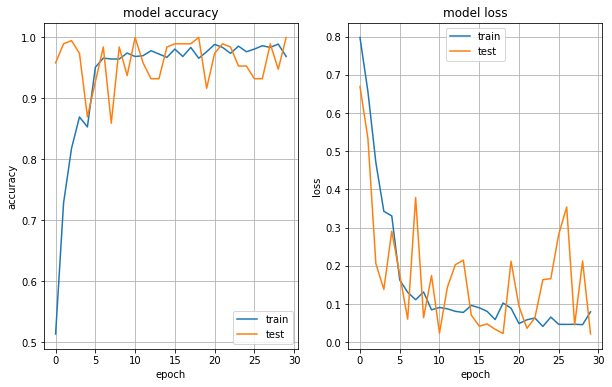

In [10]:
import matplotlib
from plotutils import plot_learning_curves_from_history_file
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10, 6)
fig = plot_learning_curves_from_history_file("/tf/notebooks/history/new_trained_model_on_docker.csv")

## Export model to SavedModelFormat

In [11]:
import shutil 
import os

def convert_from_keras_to_savedmodel(input_filename, export_path):
    tf.keras.backend.clear_session()
    tf.keras.backend.set_learning_phase(0)
    model = tf.keras.models.load_model(input_filename)

    if os.path.exists(export_path):
        shutil.rmtree(export_path)

    # Fetch the Keras session and save the model
    with tf.keras.backend.get_session() as sess:
        tf.saved_model.simple_save(
            sess,
            export_path,
            inputs={'input_image': model.input},
            outputs={t.name:t for t in model.outputs})

In [12]:
WORKSPACE_FOLDER_PATH="/tf/notebooks/"

In [13]:
convert_from_keras_to_savedmodel(
    input_filename=WORKSPACE_FOLDER_PATH+'/cpkt/febrero-cpu-friendly_weights.27-0.01.hdf5',
    export_path=WORKSPACE_FOLDER_PATH+'/models/febrero-cpu-friendly_weights.1'
)